In [2]:
# importação de bibliotecas
import geopandas as gpd
import rasterio
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
# Caminhos dos arquivos
path_raster = "raster_empilhado.tif"
path_pontos = "shapeocorrencias_inventario.shp"

In [4]:
# Ler shapefile de ocorrências
gdf = gpd.read_file(path_pontos)
print("="*60)
print("ANÁLISE DO DATASET DE TREINAMENTO")
print("="*60)
print(f"Total de pontos: {len(gdf)}")
print(f"Colunas disponíveis: {list(gdf.columns)}")
print(f"\nDistribuição de classes:")
print(gdf['classe'].value_counts())
print(f"\nBalanceamento:")
for classe, count in gdf['classe'].value_counts().items():
    pct = (count/len(gdf))*100
    print(f"  Classe {int(classe)}: {count} pontos ({pct:.1f}%)")

ANÁLISE DO DATASET DE TREINAMENTO
Total de pontos: 302
Colunas disponíveis: ['classe', 'layer', 'path', 'geometry']

Distribuição de classes:
classe
0    151
1    151
Name: count, dtype: int64

Balanceamento:
  Classe 0: 151 pontos (50.0%)
  Classe 1: 151 pontos (50.0%)


In [5]:
# Extrair valores do raster nas coordenadas EXATAS dos pontos 
print("\n" + "="*60)
print("EXTRAINDO VALORES DO RASTER NOS PONTOS DE OCORRÊNCIA")
print("="*60)

with rasterio.open(path_raster) as src:
    # Preparar coordenadas dos pontos (x, y)
    coords = [(geom.x, geom.y) for geom in gdf.geometry]
    
    # Extrair valores de todas as bandas para cada ponto
    sampled_values = []
    for val in src.sample(coords):
        sampled_values.append(val)
    
    # Nomes das colunas atributos
    colunas = [
    # Índices espectrais
    'NDVI', 'NDWI', 'NDBI', 'MNDWI', 'SAVI', 'BSI',

    # Variáveis topográficas e hidrológicas (ordem real no raster)
    'TWI',
    'Altitude', 'Curvatura_H', 'Curvatura_V', 'Declividade',
    'Divisores', 'Forma_terreno', 'Orientacao', 'Relevo'
    ]
    
    # Converter para DataFrame
    df = pd.DataFrame(sampled_values, columns=colunas)
    
    # Adicionar coluna de classe dos pontos de ocorrência
    df['Classe'] = gdf['classe'].values



EXTRAINDO VALORES DO RASTER NOS PONTOS DE OCORRÊNCIA


In [6]:
# Remover linhas com NaN
print(f"\nDimensão antes de limpar NaN: {df.shape}")
df = df.dropna().reset_index(drop=True)
print(f"Dimensão após remover NaN: {df.shape}")

print(f"\nDistribuição final de classes após limpeza:")
print(df['Classe'].value_counts())
print(f"\nBalanceamento final:")
for classe, count in df['Classe'].value_counts().items():
    pct = (count/len(df))*100
    print(f"  Classe {int(classe)}: {count} amostras ({pct:.1f}%)")


Dimensão antes de limpar NaN: (302, 16)
Dimensão após remover NaN: (302, 16)

Distribuição final de classes após limpeza:
Classe
0    151
1    151
Name: count, dtype: int64

Balanceamento final:
  Classe 0: 151 amostras (50.0%)
  Classe 1: 151 amostras (50.0%)


In [7]:
# Exportar amostras para CSV 
output_csv = "amostras_inundacao.csv"
df.to_csv(output_csv, index=False)
print(f"\n✓ Dados exportados para: {output_csv}")


✓ Dados exportados para: amostras_inundacao.csv


In [8]:
# Separar X e y 
X = df.drop(columns=['Classe'])
y = df['Classe']

In [9]:
# Normalização dos dados
print("\n" + "="*60)
print("NORMALIZANDO DADOS")
print("="*60)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


NORMALIZANDO DADOS


In [9]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [10]:
# Dividir em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n Distribuição treino/teste:")
print(f"  Treino: {len(X_train)} amostras")
print(f"  Teste:  {len(X_test)} amostras")


 Distribuição treino/teste:
  Treino: 211 amostras
  Teste:  91 amostras


In [11]:
#Tuning de hiperparâmetros 
print("\n" + "="*60)
print("OTIMIZAÇÃO DE HIPERPARÂMETROS (GridSearchCV)")
print("="*60)

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None] 
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)


OTIMIZAÇÃO DE HIPERPARÂMETROS (GridSearchCV)
Fitting 10 folds for each of 648 candidates, totalling 6480 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'class_weight': ['balanced', None], 'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [13]:
# Melhor modelo
rf = grid.best_estimator_
print("\n✓ Melhores parâmetros:", grid.best_params_)
print(f"✓ Melhor AUC de validação cruzada: {grid.best_score_:.4f}")


✓ Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
✓ Melhor AUC de validação cruzada: 0.8028


In [14]:
# Avaliar no conjunto de teste
print("\n" + "="*60)
print("AVALIAÇÃO NO CONJUNTO DE TESTE")
print("="*60)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("\n Relatório de Classificação:")
print(classification_report(y_test, y_pred, 
                          target_names=['Não-inundação', 'Inundação']))

print(f"\n AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")


AVALIAÇÃO NO CONJUNTO DE TESTE

 Relatório de Classificação:
               precision    recall  f1-score   support

Não-inundação       0.70      0.72      0.71        46
    Inundação       0.70      0.69      0.70        45

     accuracy                           0.70        91
    macro avg       0.70      0.70      0.70        91
 weighted avg       0.70      0.70      0.70        91


 AUC-ROC: 0.7469


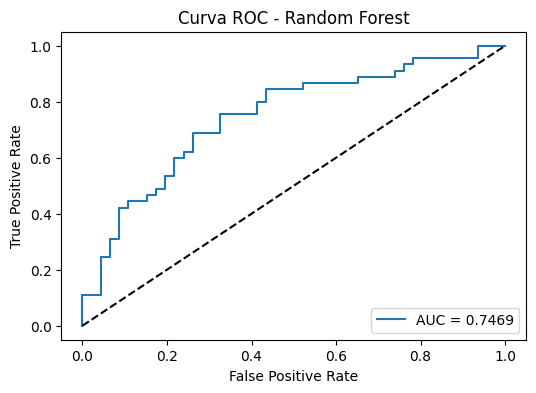

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Random Forest")
plt.legend(loc="lower right")
plt.show()



MATRIZ DE CONFUSÃO


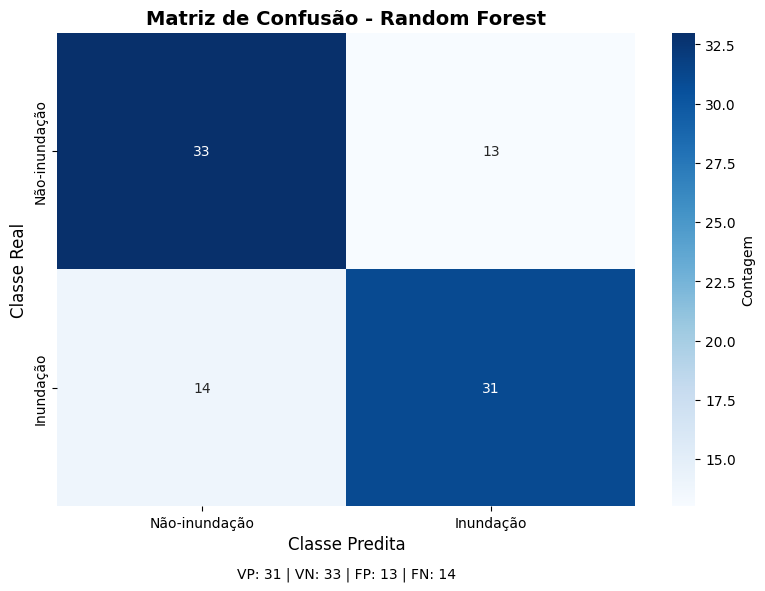


✓ Matriz de confusão salva: matriz_confusao.png

 Detalhamento:
  Verdadeiros Negativos (VN): 33
  Falsos Positivos (FP): 13
  Falsos Negativos (FN): 14
  Verdadeiros Positivos (VP): 31


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Criar matriz de confusão
print("\n" + "="*60)
print("MATRIZ DE CONFUSÃO")
print("="*60)

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Configurar o plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não-inundação', 'Inundação'],
            yticklabels=['Não-inundação', 'Inundação'],
            cbar_kws={'label': 'Contagem'})

plt.title('Matriz de Confusão - Random Forest', 
    fontsize=14, fontweight='bold')
plt.ylabel('Classe Real', fontsize=12)
plt.xlabel('Classe Predita', fontsize=12)

# Adicionar estatísticas
plt.text(0.5, -0.15, 
         f'VP: {cm[1,1]} | VN: {cm[0,0]} | FP: {cm[0,1]} | FN: {cm[1,0]}',
         ha='center', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.savefig('matriz_confusao.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Matriz de confusão salva: matriz_confusao.png")
print(f"\n Detalhamento:")
print(f"  Verdadeiros Negativos (VN): {cm[0,0]}")
print(f"  Falsos Positivos (FP): {cm[0,1]}")
print(f"  Falsos Negativos (FN): {cm[1,0]}")
print(f"  Verdadeiros Positivos (VP): {cm[1,1]}")
print("="*60)


In [93]:
# Importância das variáveis 
print("\n" + "="*60)
print("IMPORTÂNCIA DAS VARIÁVEIS")
print("="*60)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

print("\nRanking de importância:")
for i, idx in enumerate(indices, 1):
    print(f"{i:2d}. {features[idx]:15s}: {importances[idx]:.4f} ({importances[idx]*100:.1f}%)")


IMPORTÂNCIA DAS VARIÁVEIS

Ranking de importância:
 1. TWI            : 0.1653 (16.5%)
 2. Curvatura_V    : 0.1514 (15.1%)
 3. Altitude       : 0.0847 (8.5%)
 4. Curvatura_H    : 0.0754 (7.5%)
 5. NDWI           : 0.0711 (7.1%)
 6. MNDWI          : 0.0647 (6.5%)
 7. SAVI           : 0.0532 (5.3%)
 8. NDBI           : 0.0527 (5.3%)
 9. NDVI           : 0.0517 (5.2%)
10. Declividade    : 0.0501 (5.0%)
11. Relevo         : 0.0491 (4.9%)
12. BSI            : 0.0357 (3.6%)
13. Forma_terreno  : 0.0346 (3.5%)
14. Orientacao     : 0.0327 (3.3%)
15. Divisores      : 0.0276 (2.8%)


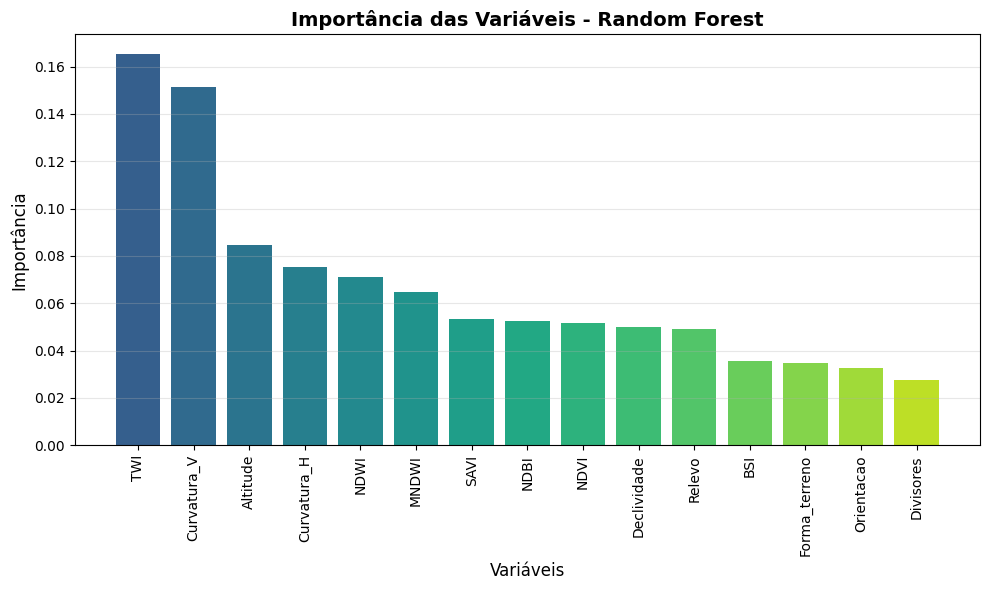

In [94]:
# Visualizar importância
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features)))
plt.bar(range(len(features)), importances[indices], color=colors)
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.title("Importância das Variáveis - Random Forest", fontsize=14, fontweight='bold')
plt.ylabel("Importância", fontsize=12)
plt.xlabel("Variáveis", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("importancia_variaveis.png", dpi=300)
plt.show()

In [95]:
# Salvar modelo E scaler
print("\n" + "="*60)
print("SALVANDO MODELO E SCALER")
print("="*60)
joblib.dump(rf, "modelo_inundacao_RF.pkl")
joblib.dump(scaler, "scaler_inundacao.pkl")
print(" Modelo salvo: modelo_inundacao_RF.pkl")
print(" Scaler salvo: scaler_inundacao.pkl")
print("="*60)


SALVANDO MODELO E SCALER
 Modelo salvo: modelo_inundacao_RF.pkl
 Scaler salvo: scaler_inundacao.pkl


In [ ]:
==================================================================================================

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc


In [12]:
print("\n" + "="*60)
print("TREINAMENTO - REDE NEURAL ARTIFICIAL (MLP)")
print("="*60)

mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),   # duas camadas ocultas
    activation='relu',
    solver='adam',
    alpha=0.001,                   # regularização
    batch_size=32,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)

mlp.fit(X_train, y_train)



TREINAMENTO - REDE NEURAL ARTIFICIAL (MLP)


,hidden_layer_sizes,"(32, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.001
,batch_size,32
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,42


In [13]:
y_pred_mlp = mlp.predict(X_test)
y_pred_proba_mlp = mlp.predict_proba(X_test)[:, 1]


In [14]:
print("\n Relatório de Classificação - RNA:")
print(classification_report(
    y_test, y_pred_mlp,
    target_names=['Não-inundação', 'Inundação']
))



 Relatório de Classificação - RNA:
               precision    recall  f1-score   support

Não-inundação       0.67      0.65      0.66        46
    Inundação       0.65      0.67      0.66        45

     accuracy                           0.66        91
    macro avg       0.66      0.66      0.66        91
 weighted avg       0.66      0.66      0.66        91



In [15]:
auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)
print(f"\n AUC-ROC - RNA: {auc_mlp:.4f}")



 AUC-ROC - RNA: 0.6964


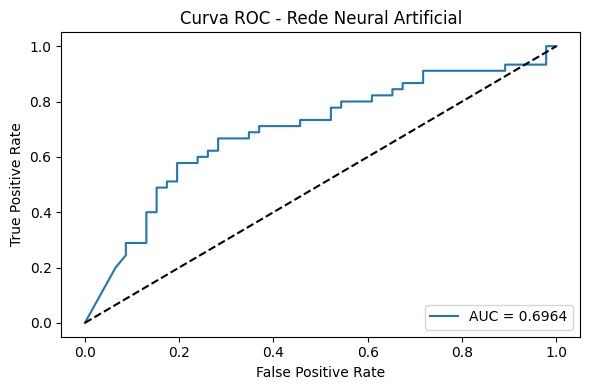

In [16]:
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_proba_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(6,4))
plt.plot(fpr_mlp, tpr_mlp, label=f'AUC = {roc_auc_mlp:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Rede Neural Artificial")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


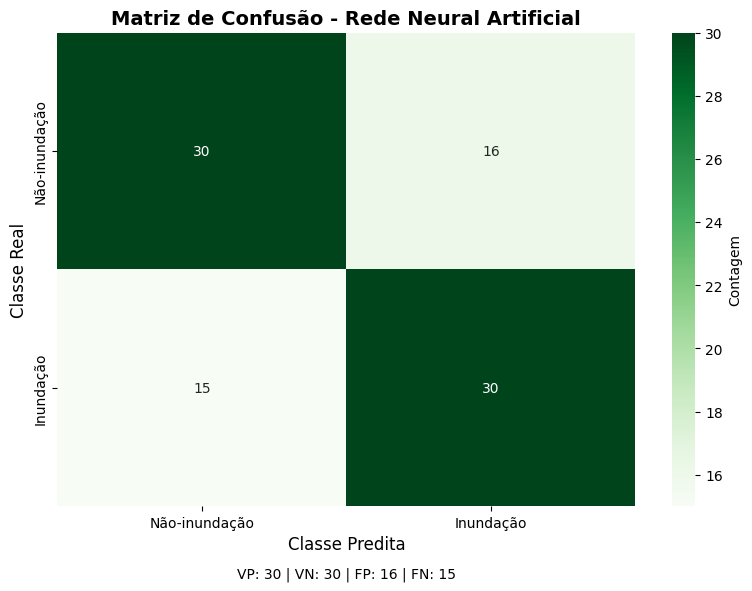

In [17]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_mlp, annot=True, fmt='d', cmap='Greens',
    xticklabels=['Não-inundação', 'Inundação'],
    yticklabels=['Não-inundação', 'Inundação'],
    cbar_kws={'label': 'Contagem'}
)

plt.title('Matriz de Confusão - Rede Neural Artificial',
          fontsize=14, fontweight='bold')
plt.ylabel('Classe Real', fontsize=12)
plt.xlabel('Classe Predita', fontsize=12)

plt.text(0.5, -0.15,
         f'VP: {cm_mlp[1,1]} | VN: {cm_mlp[0,0]} | FP: {cm_mlp[0,1]} | FN: {cm_mlp[1,0]}',
         ha='center', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.savefig('matriz_confusao_RNA.png', dpi=300, bbox_inches='tight')
plt.show()
